In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
                                                  
from general_tools.in_out.basics import create_dir, files_in_subdirs

from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, convolutional_discriminator,\
                                                          point_cloud_generator, leaky_relu

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
seed = 42


is_convolutional = False
save_model = False
save_synthetic_samples = False

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'


if is_convolutional:
    arch_tag = 'convolutional_arch'
    discriminator = convolutional_discriminator
    adaptive_training = 0.8
else:
    arch_tag = 'mlp_arch'
    discriminator = mlp_discriminator
    adaptive_training = None

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
training_data = PointCloudDataSet(full_pclouds)

6778 files containing complete point clouds were found.


In [11]:
max_epochs = 100
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}

noise_dim = 512
init_lr = 0.0005

n_syn_samples = training_data.num_examples  # Same number as original GT data.
accum_syn_data = []
train_stats = []

reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_samples, 3], noise_dim,
             discriminator, point_cloud_generator, 
             disc_kwargs={})

In [12]:
if do_training:
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)
        accum_syn_data.append(gan.generate(n_syn_samples, noise_params))

1 (1.3735784354033294, 0.7556095860622547) 29.0256268978
2 (1.3304583589235941, 0.90828916452549124) 28.7992649078
3 (1.3485672641683508, 0.82066789070765178) 29.250387907
4 (1.3296088465937861, 0.87438509685021859) 29.7527930737
5 (1.2961017582151624, 0.93344925421255609) 29.7143759727
6 (1.2476934865668967, 0.9322345704944045) 29.7363128662
7 (1.2435097402996487, 0.96216598131038522) 30.1476769447
8 (1.2119955592685276, 1.0267300256976375) 29.8537390232
9 (1.2322260397451896, 1.0170121446803764) 30.1227509975
10 (1.177968720153526, 1.0822284976641336) 29.997936964
11 (1.1208610124058194, 1.158309852193903) 29.799861908
12 (1.107780800483845, 1.2431283836011533) 29.7117190361
13 (1.0624480830298531, 1.29167799949646) 29.7895038128
14 (1.0298539404515867, 1.3928463500958901) 29.828565836
15 (1.0592897057533264, 1.3755908573115314) 29.6449429989
16 (1.0106496139808938, 1.3954080470182277) 29.6754078865
17 (0.92990054157045154, 1.5216844042142232) 29.7320981026
18 (0.95192687025776612, 1

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Raw GAN training. (%s, %s)' % (class_name, arch_tag) )
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
if save_synthetic_samples:    
    save_dir = osp.join(synthetic_data_out_dir, experiment_name)
    create_dir(save_dir)
    epochs_to_save = range(1, 100, 5) # Save every 5 epochs
    for i in epochs_to_save:
        np.savez(osp.join(save_dir, 'epoch_' + str(i)), accum_syn_data[i-1])

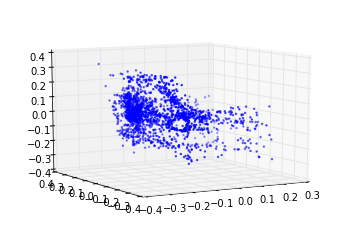

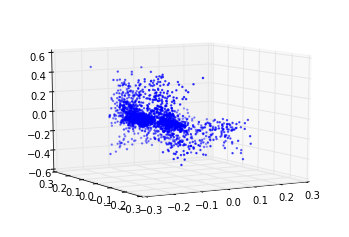

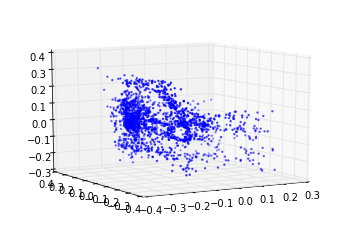

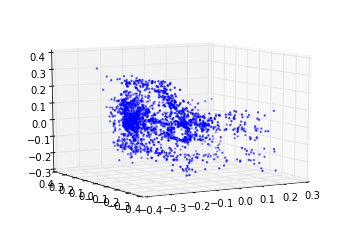

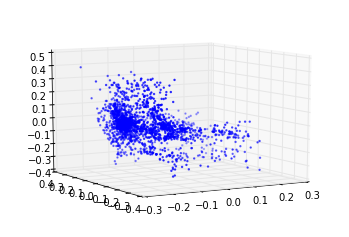

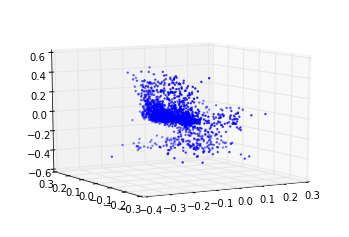

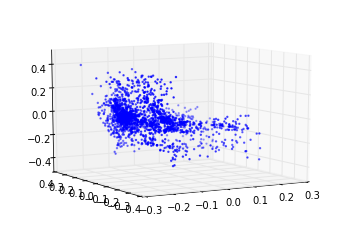

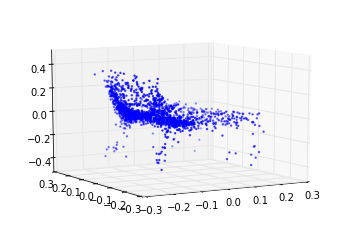

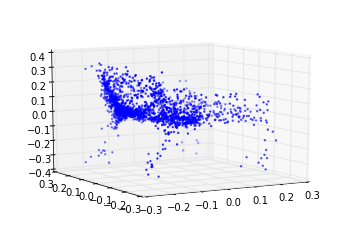

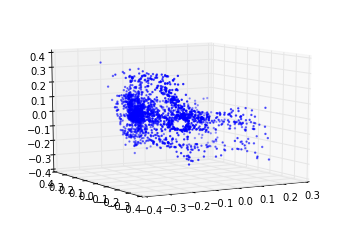

In [13]:
epoch_to_check = 50
n_check = 10
check_data = accum_syn_data[epoch_to_check-1]
rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
for i in range(n_check):
    Point_Cloud(check_data[rids[i]]).plot()    